In [15]:
from IPython.display import Image, display
from dotenv import load_dotenv
from langchain.tools import tool
from langchain_core.messages import HumanMessage
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import MessagesState, StateGraph, END
from langgraph.prebuilt import tools_condition
# Import organization: Additional components for persistent memory
from langgraph.store.base import BaseStore
from pydantic import BaseModel, Field
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint

load_dotenv()

True

In [16]:
llm = ChatOpenAI(model="deepseek-chat", temperature=1.3)
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2",
                                   model_kwargs={"local_files_only": True, "device": "cpu"})

In [17]:
class ScratchpadState(MessagesState):
    scratchpad: str = Field(description="The scratchpad for storing notes")


@tool
class WriteToScratchpad(BaseModel):
    notes: str = Field(description="Notes to save to the scratchpad")


@tool
class ReadFromScratchpad(BaseModel):
    reasoning: str = Field(description="Reasoning for reading from the scratchpad")


search_tool = TavilySearch(
        max_results=3, topic="general"
)

tools = [ReadFromScratchpad, WriteToScratchpad, search_tool]

tool_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

scratchpad_prompt = """You are an advanced research assistant equipped with web search capabilities and a persistent scratchpad system for systematic knowledge management.

## Core Research Methodology:

### Phase 1: Foundation & Planning
- **Scratchpad Review**: Begin by examining your scratchpad for existing relevant research, insights, or partial work that could inform your current task
- **Context Assessment**: Evaluate what you already know versus what needs to be discovered
- **Strategic Planning**: Develop a comprehensive, structured research plan with clear objectives, key questions, and search strategies
- **Documentation**: Record your research plan, hypotheses, and initial thoughts in the scratchpad

### Phase 2: Active Research & Discovery
- **Targeted Searching**: Execute systematic web searches aligned with your research plan
- **Real-time Documentation**: After each search, immediately update your scratchpad with:
  - New findings and data points
  - Source credibility assessments
  - Connections to previous research
  - Emerging patterns or contradictions
  - Gaps that require further investigation

### Phase 3: Analysis & Synthesis
- **Cross-referencing**: Compare findings across sources and previous research
- **Critical Evaluation**: Assess information quality, bias, and reliability
- **Pattern Recognition**: Identify trends, relationships, and insights
- **Continuous Updates**: Refine your understanding and update scratchpad accordingly

### Phase 4: Iteration & Refinement
- **Gap Analysis**: Identify remaining questions or weak evidence
- **Follow-up Research**: Conduct additional targeted searches as needed
- **Knowledge Integration**: Synthesize new information with existing research
- **Quality Assurance**: Verify key facts and resolve contradictions

### Phase 5: Completion & Delivery
- **Comprehensive Response**: Provide thorough, well-supported answers based on accumulated research
- **Source Documentation**: Include proper attribution and evidence
- **Future-Ready Notes**: Ensure scratchpad contains organized, reusable research for potential follow-up questions

## Available Research Tools:
- **WriteToScratchpad**: Persistent storage for research plans, findings, insights, and progress tracking
- **ReadFromScratchpad**: Retrieval of previous research work, notes, and accumulated knowledge
- **TavilySearch**: Web search for current information, data, and diverse perspectives

## Quality Standards:
- Maintain organized, chronological notes with clear categorization
- Build systematically upon previous research rather than starting from scratch
- Prioritize accuracy, comprehensiveness, and critical analysis
- Document both confirmatory and contradictory evidence
- Create a knowledge base that supports both immediate needs and future research

Your scratchpad is your research memory - use it strategically to become more effective with each interaction."""


def llm_call(state: ScratchpadState) -> dict:
    return {
        "messages": [
            llm_with_tools.invoke(
                    [SystemMessage(content=scratchpad_prompt)] + state["messages"]
            )
        ]
    }


def tool_node(state: ScratchpadState) -> dict:
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tool_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])

        if tool_call["name"] == "WriteToScratchpad":
            notes = observation.notes
            result.append(ToolMessage(content=f"Wrote to scratchpad: {notes}", tool_call_id=tool_call["id"]))
            update = {"messages": result, "scratchpad": notes}

        elif tool_call["name"] == "ReadFromScratchpad":
            # Retrieve notes from the scratchpad
            notes = state.get("scratchpad", "")
            result.append(ToolMessage(content=f"Notes from scratchpad: {notes}", tool_call_id=tool_call["id"]))
            update = {"messages": result}

        elif tool_call["name"] == "tavily_search":
            # Write search tool observation to messages
            result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
            update = {"messages": result}
    return update



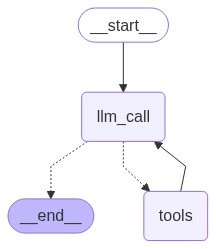

In [18]:
agent_builder = StateGraph(ScratchpadState)

agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tools", tool_node)
agent_builder.set_entry_point("llm_call")
agent_builder.add_edge("tools", "llm_call")
agent_builder.add_conditional_edges("llm_call", tools_condition, {
    "tools": "tools",
    END: END
})

agent = agent_builder.compile()
# Display the workflow graph
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [19]:
# Research request


query = "Compare the funding rounds and recent developments of Commonwealth Fusion Systems vs Helion Energy."

state = agent.invoke({"messages": [HumanMessage(content=query)]})

from utils import format_messages

format_messages(state['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare the funding rounds and recent developments of Commonwealth Fusion Systems vs Helion Energy.             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Commonwealth Fusion Systems funding rounds', 'follow_up_questions': None, 'answer': None, 'images':  │
│ [], 'results': [{'url': 'https://forgeglobal.com/commonwealth-fusion_ipo/', 'title': 'Commonwealth Fusion IPO - │
│ Forge Global', 'content': 'Commonwealth Fusion Systems is an energy research company that uses fusion energy    │
│ and physics to create clean energy that will reverse the impact of climate change. Per Forge data, Commonwealth │
│ Fusion raised $2B billion in funding over 5 rounds. Their latest funding was raised on May 31, 2023. Key        │
│ investors include Temasek Holdings, the U.S. Department of Energy, Tiger Global Management, and Breakthrough    │
│ Energy Ventures. [...] The funding to date for Commonwealth Fusion is not currently available.\n\nCommonwealth  │
│ Fusion major investors\n\nSand Hill Angels\n\nSchooner Capital\n\nSenator Investment Group\n\nSoros Fund        │
│ Management\n\nStarbridge Venture Capital\n\nStarlight Ventures\n\nTemasek Holdings\n\nThe Engine\n\nTiger       │
│ Global Management\n\nTime Ventures\n\nShow All InvestorsShow Fewer Investors\n\n## Commonwealth Fusion funding  │
│ rounds and valuation\n\nFunding history chart\n\nFunding History is not available for this company. [...] |  |  │
│ | | | | Last Funding Round | | | |\n| --- | --- | --- | --- | --- | --- | --- | --- | --- |\n| Company | |      │
│ Forge Price | Forge Price Change 5 | Last Closed Trade | Share Class | Post-Money Valuation | Price per Share | │
│ Amount Raised |\n|  | OpenAI | $469.47 | -0.01% | $xx.xx | Funding Round | -- | -- | -- |\n|  | Anduril |       │
│ $40.88 | -3.86% | $xx.xx | Series G | $30.5B | $xx.xx | $2.5B |\n|  | Figma | $38.00 | +0.03% | $xx.xx | Series │
│ E | $10B | $xx.xx | $200MM |', 'score': 0.93511593, 'raw_content': None}, {'url':                               │
│ 'https://www.prnewswire.com/news-releases/commonwealth-fusion-systems-raises-1-8-billion-in-funding-to-commerci │
│ alize-fusion-energy-301434560.html', 'title': 'Commonwealth Fusion Systems Raises $1.8 Billion in ...',         │
│ 'content': "CAMBRIDGE, Mass., Dec. 1, 2021 /PRNewswire/ -- Commonwealth Fusion Systems (CFS) announced it has   │
│ closed on more than $1.8 billion in Series B funding to commercialize fusion energy. This includes capital to   │
│ construct, commission, and operate SPARC, the world's first commercially relevant net energy fusion machine. In │
│ addition, it will enable the company to begin work on ARC, the first commercial fusion power plant, which       │
│ includes developing support technologies, advancing the design, [...] ## Sports Overview\n\n## View All         │
│ Sports\n\n## Travel\n\n## Travel Overview\n\n## View All Travel\n\n## Policy & Public Interest\n\n## Policy &   │
│ Public Interest Overview\n\n## View All Policy & Public Interest\n\n## People & Culture\n\n## People & Culture  │
│ Overview\n\n## View All People & Culture\n\nIn-Language News\n\nPR Newswire: news distribution, targeting and   │
│ monitoring\n\nContact Us\n\n888-776-0942\n  \nfrom 8 AM - 10 PM ET\n\n# Commonwealth Fusion Systems Raises $1.8 │
│ Billion in Funding to Commercialize Fusion Energy", 'score': 0.8877607, 'raw_content': None}, {'url':           │
│ 'https://en.wikipedia.org/wiki/Commonwealth_Fusion_Systems', 'title': 'Commonwealth Fusion Systems -            │
│ Wikipedia', 'content': 'CFS was founded in 2018 as a spin-off from the MIT Plasma Science and Fusion Center.    │
│ After initial funding of $50 million in 2018 from the Italian multinational Eni, CFS closed its series A round  │
│ of venture capital funding in 2019 with a total of US$ 115 million in funding from Eni, Bill Gates\'s           │
│ Breakthrough Energy Ventures, Vinod Khosla\'s Khosla Ventures, and others. CFS raised an additional US$ 84      │
│ million in series A2 funding from Singapore\'s Temasek,

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Helion Energy funding rounds', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': │
│ [{'url': 'https://tracxn.com/d/companies/helion/__fS6qGKScel2LE9EV85bGN9zjK8uhT4s_uRFQXu4k0M8', 'title':        │
│ 'Helion - 2025 Company Profile, Team, Funding & Competitors - Tracxn', 'content': "Helion has raised a total    │
│ funding of$977M over 7 round s.Its first funding round was on Aug 16, 2011.Its latest funding round was a       │
│ Series F round on Jan 28, 2025 for $425M.6 investor s participated in its latest round,which                    │
│ includesDefense.gov, DOE, SoftBank Vision Fund and Mithril.\n\nHelion has 13 institutional investor s including │
│ Y Combinator, Mithril and Defense.gov.There are 4 Angel Investor s in Helion.\n\nHere is the list of recent     │
│ funding rounds of Helion: [...] Helion is a funded company, its first funding round was on Aug 16,              │
│ 2011.\n\nWhen was the latest funding round of Helion?\n\nHelion's latest funding round was on Jan 28,           │
│ 2025.\n\nWhere does Helion rank among its competitors?\n\nHelion ranks 2 amongst 37 active competitors.\n\nWhat │
│ does Helion do? [...] $977Min 7 rounds\n\nLatest Funding Round\n\nSeries F, Jan 28, 2025, $425M\n\nPost Money   │
│ Valuation\n\n$5.42Bas on Jan 28, 2025\n\nInvestors\n\nY Combinator&16 more\n\nRanked\n\n2 nd among37 active     │
│ competitors\n\nEmployee Count\n\n44as on Dec 31, 2022 \n\nSimilar Companies\n\nGeneral Fusion&8 more\n\nLegal   │
│ entities associated with Helion\n-------------------------------------\n\nHelion is associated with 1 legal     │
│ entit y given below:", 'score': 0.92857105, 'raw_content': None}, {'url':                                       │
│ 'https://www.helionenergy.com/articles/helion-announces-425m-series-f-investment-to-scale-commercialized-fusion │
│ -power/', 'title': 'Helion Announces $425M Series F Investment to Scale ...', 'content': 'EVERETT, Wash. –      │
│ January 28, 2025 – Helion, a fusion energy company, today announced a $425 million Series F investment round    │
│ that will be used to scale commercialization efforts for the company’s groundbreaking fusion technology. The    │
│ oversubscribed and upsized round had participation from new investors, including Lightspeed Venture Partners,   │
│ SoftBank Vision Fund 2, and a major university endowment, and existing investors including Sam Altman, Mithril  │
│ Capital, Capricorn Investment Group, Dustin [...] Moskovitz through Good Ventures Foundation, and Nucor. This   │
│ latest round of funding will bring the total invested in Helion to over $1 billion and values the company at    │
│ $5.425 billion post-money. [...] # Helion Announces $425M Series F Investment to Scale Commercialized Fusion    │
│ Power\n\n## Round includes new investors, Lightspeed Venture Partners, SoftBank Vision Fund 2, and existing     │
│ investors\n\n---', 'score': 0.8868231, 'raw_content': None}, {'url':                                            │
│ 'https://www.neimagazine.com/news/helion-secures-425m-funding-to-commercialise-its-fusion-technology/',         │
│ 'title': 'Helion secures $425m funding to commercialise its fusion ...', 'content': 'US-based fusion energy     │
│ company Helion has raised $425m in a Series F investment round to advance the commercialisation of its fusion   │
│ energy technology.\n\nExisting investors including Sam Altman, Mithril Capital, Capricorn Investment Group,     │
│ Dustin Moskovitz through Good Ventures Foundation, and Nucor participated in the Series F round. [...]          │
│ Additionally, new investors Lightspeed Venture Partners, SoftBank Vision Fund 2, and a major university         │
│ endowment, participated in the oversubscribed and upsized funding round.\n\nThe latest funding round brings the │
│ total investment in Helion to more than $1bn and values

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Commonwealth Fusion Systems recent developments', 'follow_up_questions': None, 'answer': None,       │
│ 'images': [], 'results': [{'url': 'https://cfs.energy/devens-campus/updates/', 'title': 'Devens Events &        │
│ Updates | Commonwealth Fusion Systems', 'content': 'CFS officially opened its new campus to support the         │
│ development and deployment of commercial fusion energy. The ceremonial event today included visits from U.S.    │
│ Secretary of Energy Jennifer M. Granholm, U.S. Senator Elizabeth Warren, U.S. Senator Edward Markey, U.S.       │
│ Representative Lori Trahan, Massachusetts Lieutenant Governor Kim Driscoll, along with a host of state and      │
│ local leaders.\n\n## New corporate headquarters and manufacturing facility completed\n\nJan 25, 2023 [...] ##   │
│ An Update from Commonwealth Fusion Systems\n\nJan 05, 2024\n\nThis is the second video in a series of the       │
│ latest updates from inside CFS. In this episode, CEO Bob Mumgaard and VP of Production Darby Dunn share major   │
│ milestones CFS has achieved since June 2023 that have helped to accelerate our path to commercial fusion.\n\n## │
│ Motor generator centerpiece delivered\n\nNov 13, 2023 [...] ## CFS-MIT High-Field Magnet Technology for         │
│ Commercial Fusion Experimentally Validated\n\nMar 04, 2024', 'score': 0.78214747, 'raw_content': None}, {'url': │
│ 'https://cfs.energy/news-and-media/', 'title': 'Press | Commonwealth Fusion Systems', 'content': "Commonwealth  │
│ Fusion Systems\n\n# CFS in the News\n\nCommonwealth Fusion Systems, 08.06.2025\n\n## Commonwealth Fusion        │
│ Systems Names Christopher P. LiddellÂ to Board of Directors\n\nCommonwealth Fusion Systems' Tokamak Hall, the   │
│ home of the SPARC fusion machine\n\nCommonwealth Fusion Systems, 06.30.2025\n\n## Google and Commonwealth       │
│ Fusion Systems Sign Strategic Partnership\n\nTwo workers manufacture a superconducting cable at Commonwealth    │
│ Fusion Systems' magnet factory.\n\n, 02.11.2025 [...] An aerial view of the plus-shaped building that houses    │
│ the SPARC tokamak, a fusion machine built by Commonwealth Fusion Systems\n\nCommonwealth Fusion Systems,        │
│ 10.24.2024\n\n## Commonwealth Fusion Systems Granted Radioactive Materials License for SPARC Fusion             │
│ Machine\n\nCommonwealth Fusion Systems, 08.09.2024\n\n## Commonwealth Fusion Systems Wins Two DOE INFUSE Awards │
│ to Help Commercialize Fusion Energy [...] A cutaway illustration of ARC showing the magnets and glowing plasma  │
│ inside the fusion power plant\n\nCommonwealth Fusion Systems, 11.04.2024\n\n## ARPA-E award boosts CFSâ\x80\x99 │
│ quest for the best fusion power plant materials\n\nCommonwealth Fusion Systems, 10.30.2024\n\n## Commonwealth   │
│ Fusion Systemsâ\x80\x99 second breakthrough superconducting technology handles mammoth pulses of power",        │
│ 'score': 0.7251239, 'raw_content': None}, {'url':                                                               │
│ 'https://cfs.energy/news-and-media/google-and-commonwealth-fusion-systems-sign-strategic-partnership', 'title': │
│ 'Google and Commonwealth Fusion Systems Sign Strategic ...', 'content': "Commonwealth Fusion Systems\n\n#       │
│ Google and Commonwealth Fusion Systems Sign Strategic Partnership\n\nCommonwealth Fusion Systems' Tokamak Hall, │
│ the home of the SPARC fusion machine\n\nMOUNTAIN VIEW, Calif., and DEVENS, Mass. (June 30, 2025) â\x80\x94      │
│ Google and Commonwealth Fusion Systems (CFS) today announced a new global milestone, a bold partnership to      │
│ develop, deploy and scale clean, secure fusion power. [...] The agreement validates that CFS is developing one  │
│ of the most promising paths to commercial fusion power in the coming decade. CFS expects that its Chesterfield  │
│ County ARC power plant will be the first grid-scale fus

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Helion Energy recent developments', 'follow_up_questions': None, 'answer': None, 'images': [],       │
│ 'results': [{'url': 'https://www.world-nuclear-news.org/articles/helion-begins-work-on-fusion-power-plant',     │
│ 'title': 'Helion begins work on fusion power plant - World Nuclear News', 'content': 'The company has           │
│ previously built six working prototypes and in June 2021 became the first private fusion company to reach       │
│ 100-million-degree plasma temperatures with its sixth fusion generator prototype, Trenta. Helion\'s seventh     │
│ prototype, Polaris, in Everett, Washington, began initial operations in 2024. [...] World Nuclear News\n\n#     │
│ Helion begins work on fusion power plant\n\nShare on socials\nHelion begins work on fusion power                │
│ plant_56455.jpg)\n\nHelion is developing what it says is a cost-effective, zero-carbon electrical power plant   │
│ using its patented pulsed, non-ignition fusion technology. The company says its fusion power plant will provide │
│ "flexible, scalable, baseload power that is affordable, providing the world a new path to full decarbonisation  │
│ of electricity generation". [...] It earlier said that it expects Orion, its first power plant, to be online by │
│ 2028 and will target power generation of 50 MWe or greater after a one-year ramp-up period.\n\nIn May 2023,     │
│ Microsoft signed an agreement with Helion for the provision of electricity from its first fusion power plant.   │
│ Constellation Energy will serve as the power marketer and will manage transmission for the project.', 'score':  │
│ 0.66203266, 'raw_content': None}, {'url':                                                                       │
│ 'https://carboncredits.com/microsoft-msft-to-get-fusion-power-as-helion-energy-kicks-off-orion-plant-constructi │
│ on/', 'title': 'Microsoft (MSFT) to Get Fusion Power as Helion Energy Kicks Off ...', 'content': 'Over the past │
│ decade, Helion has built six fusion prototypes and made steady technical progress through rapid iteration and   │
│ testing. Its sixth machine, Trenta, made history by achieving a fuel temperature of 100 million degrees         │
│ Celsius—considered the minimum threshold for fusion to become commercially viable. [...] In 2023, Helion signed │
│ the world’s first power purchase agreement (PPA) for fusion energy, committing to supply electricity to         │
│ Microsoft once the plant is operational. Located in Chelan County, Washington, the site was selected for its    │
│ easy access to power transmission and its legacy of energy innovation. [...] Since 2023, Helion has actively    │
│ collaborated with government agencies, Tribal Nations, and local stakeholders to prepare for the construction   │
│ and operation phases. The company’s transparent approach to permitting and community engagement has helped      │
│ smooth the path for the project.', 'score': 0.66045773, 'raw_content': None}, {'url':                           │
│ 'https://www.helionenergy.com/news/', 'title': 'News - Helion', 'content': "Fusion Energy Startup Helion Energy │
│ Closes Latest Funding Round at $1.25B Valuation. The company raised $40 million in Series D funding,            │
│ accelerating Helion's", 'score': 0.5382315, 'raw_content': None}], 'response_time': 4.38}                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: ### Funding Rounds Comparison                                                              │
│                                                                                                                 │
│ #### Commonwealth Fusion Systems (CFS)                                                                          │
│ 1. **Total Funding**: Over $2 billion across 5 rounds (as of May 2023).                                         │
│ 2. **Key Investors**: Temasek Holdings, U.S. Department of Energy, Tiger Global Management, Breakthrough Energy │
│ Ventures, Eni, Bill Gates.                                                                                      │
│ 3. **Latest Round**: $1.8 billion Series B in November 2021 for SPARC tokamak development.                      │
│ 4. **Additional Funding**: Received grants from the U.S. Department of Energy in 2023.                          │
│                                                                                                                 │
│ #### Helion Energy                                                                                              │
│ 1. **Total Funding**: Over $1 billion across 7 rounds (as of January 2025).                                     │
│ 2. **Key Investors**: Defense.gov, DOE, SoftBank Vision Fund, Mithril, Sam Altman.                              │
│ 3. **Latest Round**: $425 million Series F in January 2025 for scaling commercialization.                       │
│ 4. **Post-Money Valuation**: $5.425 billion (as of January 2025).                                               │
│                                                                                                                 │
│ ### Recent Developments                                                                                         │
│                                                                                                                 │
│ #### Commonwealth Fusion Systems                                                                                │
│ 1. **SPARC Development**: Construction and commissioning of SPARC, the first commercially relevant net energy   │
│ fusion machine.                                                                                                 │
│ 2. **ARC Power Plant**: Began work on ARC, the first commercial fusion power plant.                             │
│ 3. **Partnerships**: Collaborated with Eni (March 2023) and Google (June 2025) for strategic partnerships.      │
│ 4. **Facility**: Opened a new campus in Devens, Massachusetts, for fusion energy development.                   │
│                                                                                                                 │
│ #### Helion Energy                                                                                              │
│ 1. **Prototypes**: Built six working prototypes; Polaris prototype operational in 2024.                         │
│ 2. **Polaris Plant**: Began construction of its first fusion power plant, Orion, targeting 50 MWe output by     │
│ 2028.                                                                                                           │
│ 3. **Partnerships**: Signed a power purchase agreement with Microsoft (May 2023) for electricity supply.        │
│ 4. **Community Engagement**: Actively collaborating with local stakeholders for project development.            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Here’s a comprehensive comparison of **Commonwealth Fusion Systems (CFS)** and **Helion Energy** based on their │
│ funding rounds and recent developments:                                                                         │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ### **Funding Rounds**                                                                                          │
│                                                                                                                 │
│ #### **Commonwealth Fusion Systems (CFS)**                                                                      │
│ - **Total Funding**: Over $2 billion across 5 rounds (as of May 2023).                                          │
│ - **Key Investors**: Temasek Holdings, U.S. Department of Energy, Tiger Global Management, Breakthrough Energy  │
│ Ventures, Eni, and Bill Gates.                                                                                  │
│ - **Latest Round**: $1.8 billion Series B in November 2021 for the development of SPARC, the first commercially │
│ relevant net energy fusion machine.                                                                             │
│ - **Additional Funding**: Received grants from the U.S. Department of Energy in 2023.                           │
│                                                                                                                 │
│ #### **Helion Energy**                                                                                          │
│ - **Total Funding**: Over $1 billion across 7 rounds (as of January 2025).                                      │
│ - **Key Investors**: Defense.gov, DOE, SoftBank Vision Fund, Mithril, and Sam Altman.                           │
│ - **Latest Round**: $425 million Series F in January 2025 to scale commercialization efforts.                   │
│ - **Post-Money Valuation**: $5.425 billion (as of January 2025).                                                │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ### **Recent Developments**                                                                                     │
│                                                                                                                 │
│ #### **Commonwealth Fusion Systems (CFS)**                                                                      │
│ 1. **SPARC Tokamak**: Construction and commissioning underway for the world’s first commercially relevant net   │
│ energy fusion machine.                                                                                          │
│ 2. **ARC Power Plant**: Development initiated for the first commercial fusion power plant.                      │
│ 3. **Strategic Partnerships**:                                                                                  │
│    - Collaborated with **Eni** (March 2023) for components and authorizations.                                  │
│    - Signed a partnership with **Google** (June 2025) to develop and scale fusion power.                        │
│ 4. **Facilities**: Opened a new campus in Devens, Massachusetts, to support fusion energy development.          │
│                                                        

In [20]:

console = Console()
console.print("\n[bold green]Scratchpad:[/bold green]")

Markdown(state['scratchpad'])

Scratchpad:

Funding Rounds Comparison                                             

                                         Commonwealth Fusion Systems (CFS)                                         

 1 Total Funding: Over $2 billion across 5 rounds (as of May 2023).                                                
 2 Key Investors: Temasek Holdings, U.S. Department of Energy, Tiger Global Management, Breakthrough Energy        
   Ventures, Eni, Bill Gates.                                                                                      
 3 Latest Round: $1.8 billion Series B in November 2021 for SPARC tokamak development.                             
 4 Additional Funding: Received grants from the U.S. Department of Energy in 2023.                                 

                                                   Helion Energy                                                   

 1 Total Funding: Over $1 billion across 7 rounds (as of January 2025).                                            
 2 Key Investors: Defense.gov, DOE, SoftBank Vision Fund, Mithril, Sam Altman.                                     
 3 Latest Round: $425 million Series F in January 2025 for scaling commercialization.                              
 4 Post-Money Valuation: $5.425 billion (as of January 2025).                                                      

                                                Recent Developments                                                

                                            Commonwealth Fusion Systems                                            

 1 SPARC Development: Construction and commissioning of SPARC, the first commercially relevant net energy fusion   
   machine.                                                                                                        
 2 ARC Power Plant: Began work on ARC, the first commercial fusion power plant.                                    
 3 Partnerships: Collaborated with Eni (March 2023) and Google (June 2025) for strategic partnerships.             
 4 Facility: Opened a new campus in Devens, Massachusetts, for fusion energy development.                          

                                                   Helion Energy                                                   

 1 Prototypes: Built six working prototypes; Polaris prototype operational in 2024.                                
 2 Polaris Plant: Began construction of its first fusion power plant, Orion, targeting 50 MWe output by 2028.      
 3 Partnerships: Signed a power purchase agreement with Microsoft (May 2023) for electricity supply.               
 4 Community Engagement: Actively collaborating with local stakeholders for project development.

# Offloading via memory

In [21]:
from langgraph.store.memory import InMemoryStore

store = InMemoryStore()

namespace = ("rlm", "scratchpad")
store.put(
        namespace,
        "scratchpad",
        {
            "scratchpad": "Research project on renewable energy adoption in developing countries. Key areas to track: policy frameworks, technology barriers, financing mechanisms, and success stories from pilot programs."}
)

In [22]:

scratchpad = store.get(namespace, "scratchpad")

console = Console()
console.print("\n[bold green]Retrieved Context from Memory:[/bold green]")
pprint(scratchpad)

Retrieved Context from Memory:

Item(namespace=['rlm', 'scratchpad'], key='scratchpad', value={'scratchpad': 'Research project on renewable energy adoption in developing countries. Key areas to track: policy frameworks, technology barriers, financing mechanisms, and success stories from pilot programs.'}, created_at='2025-08-13T12:45:53.597521+00:00', updated_at='2025-08-13T12:45:53.597528+00:00')

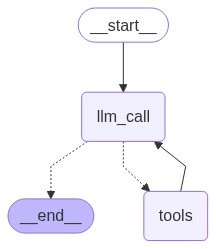

In [23]:


def tool_node_persistent(state: ScratchpadState, store: BaseStore) -> dict:
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tool_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])

        if tool_call["name"] == "WriteToScratchpad":
            # Save to a persistent store for cross-thread access
            notes = observation.notes
            result.append(ToolMessage(content=f"Wrote to scratchpad: {notes}", tool_call_id=tool_call["id"]))
            store.put(namespace, "scratchpad", {"scratchpad": notes})
            update = {"messages": result}

        elif tool_call["name"] == "ReadFromScratchpad":
            # Retrieve from persistent store across threads
            stored_data = store.get(namespace, "scratchpad")
            notes = stored_data.value["scratchpad"] if stored_data else "No notes found"
            result.append(ToolMessage(content=f"Notes from scratchpad: {notes}", tool_call_id=tool_call["id"]))
            update = {"messages": result}

        elif tool_call["name"] == "tavily_search":
            # Write search tool observation to messages
            result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
            update = {"messages": result}

    return update


# Build persistent memory workflow - enhanced version of the previous workflow
agent_builder_persistent = StateGraph(ScratchpadState)

# Add nodes (reusing llm_call, but with persistent tool node)
agent_builder_persistent.add_node("llm_call", llm_call)
agent_builder_persistent.add_node("tools", tool_node_persistent)

# Define workflow edges (same structure as basic version)
agent_builder_persistent.set_entry_point("llm_call")
agent_builder_persistent.add_conditional_edges("llm_call", tools_condition, {"tools": "tools", END: END})
agent_builder_persistent.add_edge("tools", "llm_call")

# Compile with checkpointer for thread-based state persistence
checkpointer = InMemorySaver()

# Initialize persistent memory storage component
memory_store = InMemoryStore()

# Compile with both checkpointer (for thread persistence) and store (for cross-thread memory)
agent = agent_builder_persistent.compile(checkpointer=checkpointer, store=memory_store)

# Display the enhanced workflow graph
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [24]:
config = {"configurable": {"thread_id": "1"}}

state = agent.invoke({
    "messages": [HumanMessage(
            content="Can you search for funding rounds and recent developments of Commonwealth Fusion Systems?")]
}, config)



In [25]:


console.print("\n[bold cyan]Workflow Result (Thread 1) - Kick Off Research:[/bold cyan]")
format_messages(state['messages'])

Workflow Result (Thread 1) - Kick Off Research:

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Can you search for funding rounds and recent developments of Commonwealth Fusion Systems?                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Commonwealth Fusion Systems funding rounds and recent developments', 'follow_up_questions': None,    │
│ 'answer': None, 'images': [], 'results': [{'url': 'https://cfs.energy/', 'title': 'Commonwealth Fusion Systems: │
│ Home', 'content': 'CFS has assembled a world-class team working to design, build, and scale fusion power plants │
│ that will deliver cost competitive, clean fusion energy to combat', 'score': 0.98589, 'raw_content': None},     │
│ {'url': 'https://en.wikipedia.org/wiki/Commonwealth_Fusion_Systems', 'title': 'Commonwealth Fusion Systems -    │
│ Wikipedia', 'content': 'In November 2021, the company raised an additional $1.8 billion in Series B funding to  │
│ construct and operate the SPARC tokamak, funded by Temasek Holdings, Google, Bill Gates and Eni. In December of │
│ that year, the company began construction on SPARC in Devens, Massachusetts.', 'score': 0.98554, 'raw_content': │
│ None}, {'url': 'https://cfs.energy/news-and-media/', 'title': 'Press | Commonwealth Fusion Systems', 'content': │
│ "Commonwealth Fusion Systems' second breakthrough superconducting technology handles mammoth pulses of power.", │
│ 'score': 0.98513, 'raw_content': None}], 'response_time': 2.25}                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Notes from scratchpad: No notes found                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: 1. Initial search results for Commonwealth Fusion Systems (CFS) funding rounds and recent  │
│ developments:                                                                                                   │
│    - CFS official website (https://cfs.energy/) mentions their mission to design, build, and scale fusion power │
│ plants.                                                                                                         │
│    - Wikipedia (https://en.wikipedia.org/wiki/Commonwealth_Fusion_Systems) highlights a $1.8 billion Series B   │
│ funding round in November 2021, led by investors like Temasek Holdings, Google, Bill Gates, and Eni.            │
│    - Construction of the SPARC tokamak began in December 2021 in Devens, Massachusetts.                         │
│    - CFS news page (https://cfs.energy/news-and-media/) mentions advancements in superconducting technology.    │
│                                                                                                                 │
│ Next steps: Investigate more recent funding rounds and developments, if any, beyond 2021.                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Commonwealth Fusion Systems funding rounds after 2021', 'follow_up_questions': None, 'answer': None, │
│ 'images': [], 'results': [{'url': 'https://x.com/CFS_energy/status/1947717360892137820', 'title': 'Commonwealth │
│ Fusion Systems - X', 'content': 'Association report released today shows an acceleration in fusion industry     │
│ funding growth, increasing to a total of $9.8 billion. Notable trends in the report: • Fusion companies raised  │
│ a total of $2.64 billion in the 12 months leading to July 2025. • The year’s investment total is the highest    │
│ since 2022 and a 178% rise from last year. • Over the last five years, the number of fusion companies in the    │
│ report increased from 23 to 53, and the total $9.8 billion raised is a 5x increase since 2021. [...] This       │
│ funding growth signals sustained, significant confidence in the fusion energy industry and its efforts to bring │
│ this novel technology online. The companies themselves remain optimistic: 35 of the 45 companies that responded │
│ expect to put a commercially viable net energy fusion plant online between 2030 and 2035. Funding, while not a  │
│ guarantee of success, is a necessary ingredient to making fusion energy a reality. With investors funding       │
│ multiple companies, and fusion companies exploring a', 'score': 0.9165366, 'raw_content': None}, {'url':        │
│ 'https://www.reddit.com/r/fusion/comments/1km2g7h/commonwealth_fusion_systems_raising_1_billionplus/', 'title': │
│ 'Commonwealth Fusion Systems raising $1 billion-plus Series B2', 'content': 'Image 22: r/fusion icon r/fusion•4 │
│ mo. ago Image 23: A banner for the subreddit Image 24: r/fusion iconr/fusion \nDiscussion and news on           │
│ advancements in the field of nuclear fusion energy and related technologies.\n\n  \n\n31K Members Online    ### │
│ An Update from Commonwealth Fusion Systems (December 2024)  Image 25: r/fusion - An Update from Commonwealth    │
│ Fusion Systems (December 2024)youtu    74 upvotes ·18 comments [...] Update on StockTwits Growth Mission as of  │
│ 12/27/2024Image 92: r/KenduInu_Ecosystem icon r/KenduInu_Ecosystem•5 mo. ago Image 93: A banner for the         │
│ subreddit Image 94: r/KenduInu_Ecosystem iconr/KenduInu_Ecosystem \nKendu is the narrative, and you are the     │
│ catalyst. Become the main character in the rise of the ultimate memecoin ecosystem. Will you join the pack?\n\n │
│ \n\n5.6K Members Online    ### Update on StockTwits Growth Mission as of 12/27/2024    89 upvotes ·7 comments   │
│ [...] Anyone can view, post, and comment to this community\n\nReddit RulesPrivacy PolicyUser AgreementReddit,   │
│ Inc. © 2025. All rights reserved.\n\nExpand Navigation Collapse Navigation\n\n   &nbsp; \n   &nbsp; \n\n  \n\n  │
│ TOPICS \n\n   Internet Culture (Viral) \n\n   Amazing\n   Animals & Pets\n   Cringe & Facepalm\n   Funny\n      │
│ Interesting\n   Memes\n   Oddly Satisfying\n   Reddit Meta\n   Wholesome & Heartwarming\n\n   Games', 'score':  │
│ 0.7876867, 'raw_content': None}, {'url':                                                                        │
│ 'https://www.datacenterdynamics.com/en/news/commonwealth-fusion-systems-raises-more-than-1bn-backed-by-unnamed- │
│ hyperscale-data-center-developer-report/', 'title': 'Commonwealth Fusion Systems raises more than $1bn, backed  │
│ by ...', 'content': 'Compute | New York 2026\n       Connect | Investment Series\n       Connect | Investment - │
│ New York\n       Connect | Investment - MENA\n       Connect | Investment - APAC\n       Connect | Investment - │
│ Cancún\n       Connect | Investment - London\n       Connect | Investment - Madrid\n       Digital              │
│ Infrastructure Series\n       Yotta 2025 [...] 13 May 2025  \n   The Role of Remote Power Panel in High-Density │
│ Data                                                   

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: 1. Funding rounds and developments for Commonwealth Fusion Systems (CFS):                  │
│    - In November 2021, CFS raised $1.8 billion in Series B funding (Wikipedia).                                 │
│    - A report from X (formerly Twitter) indicates the fusion industry raised $9.8 billion in total, with $2.64  │
│ billion in the 12 months leading to July 2025. This includes contributions from multiple fusion companies,      │
│ suggesting CFS may have participated in this growth.                                                            │
│    - Reddit discussions suggest CFS was raising over $1 billion in a Series B2 round as of December 2024.       │
│    - An article from Data Center Dynamics mentions CFS raising over $1 billion in 2025, backed by an unnamed    │
│ hyperscale data center developer.                                                                               │
│                                                                                                                 │
│ Next steps: Verify the accuracy of these reports and look for official announcements from CFS.                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Commonwealth Fusion Systems official announcements funding rounds 2024 2025', 'follow_up_questions': │
│ None, 'answer': None, 'images': [], 'results': [{'url':                                                         │
│ 'https://fusionxinvest.com/news/2625/12-january-2021-commonwealth-fusion-systems-closes-1-8bn-series-b/',       │
│ 'title': 'Commonwealth Fusion Systems closes $1.8bn Series B', 'content': 'Tags:Breakthrough Energy Ventures,   │
│ Coatue, Commonwealth Fusion Systems, DFJ Growth, Emerson Collective, Eni, Equinor Ventures, Fine Structure      │
│ Ventures, Footprint Coalition, Google, JIMCO, JIMCO Technology Fund, JS Capital, Safar Partners, Schooner       │
│ Capital, Senator Investment Gropu, Soros Fund Management, Starlight Ventures, Temasek, The Engine, Tiger Global │
│ Management, TIME Ventures\n\n### Google signs PPA with Commonwealth Fusion Systems\n\n30 June 2025 [...]        │
│ Exclusive member content If you are a FusionXInvest member, please login to continue reading. Not yet a member? │
│ View our subscription options or begin a trial membership today to get…\n\n### Commonwealth Fusion Systems to   │
│ build ARC in Virginia\n\n17 December 2024\n\nExclusive member content If you are a FusionXInvest member, please │
│ login to continue reading. Not yet a member? View our subscription options or begin a trial membership today to │
│ get…\n\n### CFS successfully tests key CSMC magnet [...] ### Commonwealth Fusion Systems files for power plant  │
│ permit\n\n27 May 2025\n\nExclusive member content If you are a FusionXInvest member, please login to continue   │
│ reading. Not yet a member? View our subscription options or begin a trial membership today to get…\n\n###       │
│ Commonwealth Fusion Systems starts SPARC construction\n\n25 March 2025', 'score': 0.7971311, 'raw_content':     │
│ None}, {'url':                                                                                                  │
│ 'https://bebeez.eu/2025/06/18/commonwealth-fusion-systems-cfs-launches-a-1-1-5-billion-us-dollars-round/',      │
│ 'title': 'Commonwealth Fusion Systems (CFS) launches a 1-1.5 billion US ...', 'content': 'Commonwealth Fusion   │
│ Systems (CFS) launches a 1-1.5 billion US Dollars round – BeBeez International\n\n===============\n\nImage      │
│ 1\n\n launches a 1-1.5 billion US Dollars                                                                       │
│ round\n===========================================================================\n\nImage 4: Salvatore        │
│ Brunoby Salvatore Bruno\n\nJune 18, 2025\n\n Reading Time: 3 mins read \n\ninITALY, UK&IRELAND, Uncategorized,  │
│ VENTURE CAPITAL\n\nImage 5: Commonwealth Fusion Systems (CFS) launches a 1-1.5 billion US Dollars round [...]   │
│ June 19, 2025\n\nImage 8\n\nPRIVATE EQUITY\n\n### Finnish startup Renow secures seed funding to tackle          │
│ ecommerce returns at scale\n\nJune 19, 2025\n\nImage 9\n\nSCANDINAVIA&BALTICS\n\n### Lithuanian startup Traxlo  │
│ raises €1.6 million to build the labor infrastructure for the AI era\n\nJune 19, 2025\n\n\n\n###                │
│ ItaHub\n\nImage 10: Crypto-assets supervision rules in Italy, Banca d’Italia will supervise payment systems and │
│ Consob on market abuse', 'score': 0.75290436, 'raw_content': None}, {'url':                                     │
│ 'https://cfs.energy/news-and-media/', 'title': 'Press | Commonwealth Fusion Systems', 'content': "Commonwealth  │
│ Fusion Systems,07.12.2024 Commonwealth Fusion Systems Delivers Superconducting Magnets to University of         │
│ Wisconsin's WHAM Project                                                                                        │
│ ------------------------------------------------------------------------------------------------------ [...]    │
│ Commonwealth Fusion Systems,06.24.2024 Building Trust i

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: 1. Verified updates on Commonwealth Fusion Systems (CFS) funding rounds and developments:  │
│    - In June 2025, CFS launched a funding round aiming for $1-1.5 billion (BeBeez International).               │
│    - The company has been actively involved in projects like delivering superconducting magnets to the          │
│ University of Wisconsin (December 2024) and signing a $15 million DOE agreement (June 2024).                    │
│    - CFS also won two DOE INFUSE awards in August 2024 to advance commercial fusion energy.                     │
│    - Earlier in 2021, CFS closed a $1.8 billion Series B round, as previously noted.                            │
│                                                                                                                 │
│ Key takeaway: CFS continues to secure significant funding and make progress in fusion energy technology, with   │
│ recent rounds targeting over $1 billion in 2025.                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Here’s a summary of the funding rounds and recent developments for **Commonwealth Fusion Systems (CFS)**:       │
│                                                                                                                 │
│ ### **Funding Rounds:**                                                                                         │
│ 1. **Series B (November 2021):**                                                                                │
│    - Raised **$1.8 billion**, led by investors including Temasek Holdings, Google, Bill Gates, and Eni.         │
│    - Funds were allocated for the construction of the **SPARC tokamak** in Devens, Massachusetts                │
│ ([Wikipedia](https://en.wikipedia.org/wiki/Commonwealth_Fusion_Systems)).                                       │
│                                                                                                                 │
│ 2. **Series B2 (December 2024 - June 2025):**                                                                   │
│    - Reports indicate CFS was raising **over $1 billion** in a follow-up round.                                 │
│    - By June 2025, the company aimed for **$1-1.5 billion** in new funding ([BeBeez                             │
│ International](https://bebeez.eu/2025/06/18/commonwealth-fusion-systems-cfs-launches-a-1-1-5-billion-us-dollars │
│ -round/)).                                                                                                      │
│                                                                                                                 │
│ ### **Recent Developments (2024-2025):**                                                                        │
│ - **December 2024:**                                                                                            │
│   - Delivered **superconducting magnets** to the University of Wisconsin's WHAM project ([CFS                   │
│ News](https://cfs.energy/news-and-media/)).                                                                     │
│                                                                                                                 │
│ - **June 2024:**                                                                                                │
│   - Signed a **$15 million agreement** with the U.S. Department of Energy (DOE) to advance commercial fusion    │
│ energy ([CFS News](https://cfs.energy/news-and-media/)).                                                        │
│                                                                                                                 │
│ - **August 2024:**                                                                                              │
│   - Won **two DOE INFUSE awards** to support the commercialization of fusion energy ([CFS                       │
│ News](https://cfs.energy/news-and-media/)).                                                                     │
│                                                                                                                 │
│ ### **Industry Context:**                                                                                       │
│ - The fusion energy sector has seen significant investment growth, with **$9.8 billion raised industry-wide**   │
│ as of mid-2025, including contributions from multiple companies like CFS ([X                                    │
│ Report](https://x.com/CFS_energy/status/1947717360892137820)).                                                  │
│                                                                                                                 │
│ ### **Key Takeaway:**                                                                                           │
│ CFS remains a leader in fusion energy, securing substan

In [26]:
# Cross-thread memory persistence demonstration
config_2 = {"configurable": {"thread_id": "2"}}
messages_2 = agent.invoke({
    "messages": [
        HumanMessage(content="How does the funding raised for Helion Energy compare to Commonwealth Fusion Systems?")]
}, config_2)

console.print("\n[bold cyan]Workflow Result (Thread 2) - Cross-Thread Memory Access:[/bold cyan]")
format_messages(messages_2['messages'])

Workflow Result (Thread 2) - Cross-Thread Memory Access:

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ How does the funding raised for Helion Energy compare to Commonwealth Fusion Systems?                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Helion Energy funding raised', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': │
│ [{'url': 'https://www.helionenergy.com/news/', 'title': 'News - Helion', 'content': "### Sam Altman, SoftBank   │
│ invest in $425M round for Helion, a Seattle-area startup chasing fusion power\n\nHelion Energy announced a $425 │
│ million funding round that will help the Seattle-area fusion company chase the “Holy Grail” of clean            │
│ energy.\n\nGeekWire Image 40\n\n  \n\n### Helion raises $425M to help build a fusion reactor for                │
│ Microsoft\n\nHelion announced Tuesday a $425 million Series F raise that pushed its valuation $5.245            │
│ billion.\n\nTechCrunch Image 41 [...] The company raised $40 million in Series D funding, accelerating Helion’s │
│ ability to innovate new technology that will create a path to unlimited, clean electricity from fusion.\n\nRead │
│ press release Image 80\n\nLoad more Image 81\n\nImage 82\n\nGeneral                                             │
│ Inquiries\n\ninquiries@helionenergy.com\nMedia & Press\n\npress@helionenergy.com\n\nGet our newsletter\n\nImage │
│ 83Thank you for subscribing!Something went wrong Please enter a valid email address\n\n©2025 Helion\n\n         │
│ Privacy policy\n   Terms of use\n   ©2025 Helion [...] ### Announcing Helion's latest fundraise of $500         │
│ million\n\nThis new funding will be used to accelerate our construction of Polaris, expected to demonstrate net │
│ electricity from fusion in 2024.\n\nRead press release Image 77\n\n  \n\n### Helion Energy Breaks Ground on     │
│ Site of Its Next-Generation Fusion Facility in Everett, Washington\n\nWashington Governor Jay Inslee and        │
│ Everett Mayor Cassie Franklin attend in support of the company’s expansion of operations and creation of new    │
│ clean energy jobs.", 'score': 0.8783249, 'raw_content': None}, {'url':                                          │
│ 'https://tracxn.com/d/companies/helion/__fS6qGKScel2LE9EV85bGN9zjK8uhT4s_uRFQXu4k0M8/funding-and-investors',    │
│ 'title': 'Helion - 2025 Funding Rounds & List of Investors', 'content': "Helion has raised a total of $977M     │
│ over7 funding rounds:2 Early-Stage, 3 Late-Stage and 2 Grant (prize money)round s. Helion's largest funding     │
│ round so far was aSeries Eround for $500M in Nov 2021, led bySam Altman.\n\nHere is the list of all funding     │
│ rounds of Helion: [...] How much funding has Helion raised till date?\n\nHelion has raised a total of $977M     │
│ over 7 rounds.\n\nWhich was the largest funding round of Helion?\n\nHelion's largest funding round was a Series │
│ E round held on Nov 05, 2021 for $500M.\n\nWhat is the valuation of Helion?\n\nHelion's valuation is $5.42B as  │
│ on Jan 28, 2025.\n\nHow many funding rounds does Helion have?\n\nHelion has total 7 funding rounds:\n   3       │
│ Late-Stage round s\n   2 Early-Stage round s\n   2 Grant (prize money) round s", 'score': 0.8775715,            │
│ 'raw_content': None}, {'url': 'https://news.crunchbase.com/venture/biggest-funding-rounds-helion-elevenlabs/',  │
│ 'title': "The Week's Biggest Funding Rounds: Helion Energy Takes ...", 'content': '1. Helion Energy, $425M,     │
│ energy: Fusion startup Helion Energy locked up a $425 million Series F — valuing the company at $5.4 billion —  │
│ as the company looks to commercialize its fusion technology. The round included participation from investors    │
│ including Lightspeed Venture Partners, SoftBank Vision Fund 2 and Sam Altman. The Everett, Washington-based     │
│ startup has now raised more than $1 billion. In November 2021, Helion closed a $500 million Series E. The new   │
│ round further illustrates investors’ [...] D, also led by Eden Global Partners. Founded in 2017, the company    │
│ has raised nearly $431 million, per Crunchbase. [...] 8

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Commonwealth Fusion Systems funding raised', 'follow_up_questions': None, 'answer': None, 'images':  │
│ [], 'results': [{'url': 'https://forgeglobal.com/commonwealth-fusion_ipo/', 'title': 'Commonwealth Fusion IPO - │
│ Forge Global', 'content': 'Commonwealth Fusion Systems is an energy research company that uses fusion energy    │
│ and physics to create clean energy that will reverse the impact of climate change. Per Forge data, Commonwealth │
│ Fusion raised $2B billion in funding over 5 rounds. Their latest funding was raised on May 31, 2023. Key        │
│ investors include Temasek Holdings, the U.S. Department of Energy, Tiger Global Management, and Breakthrough    │
│ Energy Ventures. [...] Commonwealth Fusion Systems was founded in 2018 by Bob Mumgaard. CNBC reported in June   │
│ 2023 that Commonwealth Fusion Systems “has raised more than $2 billion in venture capital from the likes of     │
│ Bill Gates, Gates’ climate investment firm Breakthrough Energy Ventures, Google, John Doerr, Khosla Ventures,   │
│ Lowercarbon Capital, Marc Benioff’s TIME Ventures and more. That’s more private capital than any other fusion   │
│ startup.” Commonwealth Fusion Systems has not officially endorsed a plan to', 'score': 0.945243, 'raw_content': │
│ None}, {'url':                                                                                                  │
│ 'https://www.cfs.energy/news-and-media/commonwealth-fusion-systems-closes-1-8-billion-series-b-round/',         │
│ 'title': 'Commonwealth Fusion Systems Raises $1.8 Billion in Funding to ...', 'content': 'Skip to               │
│ content\n\n12.01.2021\n\n# Commonwealth Fusion Systems Raises $1.8 Billion in Funding to Commercialize Fusion   │
│ Energy [...] Commonwealth Fusion Systems (CFS) announced it has closed on more than $1.8 billion in Series B    │
│ funding to commercialize fusion energy. This includes capital to construct, commission, and operate SPARC, the  │
│ world’s first commercially relevant net energy fusion machine. In addition, it will enable the company to begin │
│ work on ARC, the first commercial fusion power plant, which includes developing support technologies, advancing │
│ the design, identifying the site, and assembling the partners and [...] "Fusion is the kind of innovation that  │
│ can help fill the gaps in grids and put an end to fossil fuels. CFS is a company that executes - making         │
│ possible what seemed impossible, one technical milestone at a time,” said John Doerr, chair of Kleiner Perkins  │
│ and author of Speed & Scale: An Action Plan for Solving Our Climate Crisis Now.\n\nCFS has raised more than $2  │
│ billion in funding since it was founded in 2018.', 'score': 0.89121616, 'raw_content': None}, {'url':           │
│ 'https://en.wikipedia.org/wiki/Commonwealth_Fusion_Systems', 'title': 'Commonwealth Fusion Systems -            │
│ Wikipedia', 'content': 'CFS was founded in 2018 as a spin-off from the MIT Plasma Science and Fusion Center.    │
│ After initial funding of $50 million in 2018 from the Italian multinational Eni, CFS closed its series A round  │
│ of venture capital funding in 2019 with a total of US$ 115 million in funding from Eni, Bill Gates\'s           │
│ Breakthrough Energy Ventures, Vinod Khosla\'s Khosla Ventures, and others. CFS raised an additional US$ 84      │
│ million in series A2 funding from Singapore\'s Temasek, Norway\'s Equinor, and Devonshire [...] In September    │
│ 2021, the company announced the demonstration of a high temperature superconducting magnet, able to generate    │
│ magnetic fields of 20\u202fTesla. According to the New York Times, this was a successful test of "the world\'s  │
│ most powerful version of the type of magnet crucial to many fusion efforts"\n\nIn November 2021, the company    │
│ raised an additional $1.8 billion in Series B funding t

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Here is a comparison of the funding raised by Helion Energy and Commonwealth Fusion Systems (CFS):              │
│                                                                                                                 │
│ ### **Helion Energy**                                                                                           │
│ - **Total Funding Raised**: Approximately **$977 million** (as of recent reports).                              │
│   - Largest funding round: **$500 million** (Series E in November 2021).                                        │
│   - Other notable rounds:                                                                                       │
│     - **$425 million** (Series F in 2023, valuing the company at $5.4 billion).                                 │
│     - Earlier rounds include a **$40 million** Series D.                                                        │
│ - **Key Investors**: Sam Altman, SoftBank Vision Fund 2, Lightspeed Venture Partners.                           │
│ - **Valuation**: **$5.42 billion** (as of 2025).                                                                │
│                                                                                                                 │
│ ### **Commonwealth Fusion Systems (CFS)**                                                                       │
│ - **Total Funding Raised**: **Over $2 billion** (as of 2023).                                                   │
│   - Largest funding round: **$1.8 billion** (Series B in November 2021).                                        │
│   - Other notable rounds:                                                                                       │
│     - **$115 million** (Series A in 2019).                                                                      │
│     - **$84 million** (Series A2 from Temasek, Equinor, and others).                                            │
│ - **Key Investors**: Bill Gates, Breakthrough Energy Ventures, Google, Temasek Holdings, Tiger Global           │
│ Management.                                                                                                     │
│ - **Valuation**: Not explicitly stated, but significant given the scale of funding.                             │
│                                                                                                                 │
│ ### **Comparison**                                                                                              │
│ - **Total Funding**: CFS has raised more than twice as much as Helion Energy ($2B+ vs. $977M).                  │
│ - **Investor Profile**: Both companies attract high-profile investors, but CFS has a broader and more diverse   │
│ investor base, including significant contributions from government-linked entities like Temasek.                │
│ - **Focus**: Both aim to commercialize fusion energy, but CFS has emphasized large-scale infrastructure (e.g.,  │
│ SPARC tokamak), while Helion focuses on its Polaris reactor.                                                    │
│                                                                                                                 │
│ ### Summary                                                                                                     │
│ Commonwealth Fusion Systems has secured significantly more funding than Helion Energy, reflecting its           │
│ aggressive roadmap and backing from major institutional and private investors. Helion, while well-funded,       │
│ operates at a smaller scale in terms of capital raised.                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯